# CNN Fine Tuning for Cats-Dogs Classification
## CIML Summer Institute, UC San Diego
Fine-tune VGG16 top layer (Conv block 5) and fully connected layers to classify cats vs. dogs. 
Adapted from tensorflow tutorials (https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb)

------


### Setup

In [1]:
import tensorflow as tf
from tensorflow.compat.v1.keras import backend as K
from tensorflow.keras import applications
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

from sklearn.metrics import classification_report 
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import time

In [2]:
print (tf.__version__)
!python --version
print(tf.config.list_physical_devices('GPU'))
!nvidia-smi

2.3.0
Python 3.6.9
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Sat Jun 19 13:31:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:18:00.0 Off |                    0 |
| N/A   39C    P0    64W / 300W |      3MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
  

In [3]:
# Set logging level
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [4]:
# Set random generator seed
seed = 1234

# Disable hash randomization by specifying the value 0.
os.environ['PYTHONHASHSEED'] = '0'

# Set numpy random generator
np.random.seed(seed)

# Set python built-in random generator
random.seed(seed)

# Set tf global random seed
tf.random.set_seed(seed)

# Set tensorflow graph-level random seed
tf.compat.v1.random.set_random_seed(seed)

# Potential randomness from CUDNN
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC']= '1'

### Set image dimensions, location of images

In [5]:
# Image dimensions
img_width, img_height = 150, 150
IMG_SIZE = (img_width,img_height)
IMG_SHAPE = IMG_SIZE + (3,)

# Location of images
train_data_dir = '../data/catsVsDogs/train'
validation_data_dir = '../data/catsVsDogs/val'
test_data_dir = '../data/catsVsDogs/test'

# Batch size
BATCH_SIZE = 16

### Prepare data

In [6]:
# Data setup
train_datagen = ImageDataGenerator(rescale = 1. / 255, shear_range = 0.2,
                                   zoom_range = 0.2, horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1. / 255)
validation_datagen = ImageDataGenerator(rescale = 1. / 255)

# Set up generator to read images found in subfolders of training data directory,
# and indefinitely generate batches of image data (scaled).  This is for training data.
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=IMG_SIZE,
                                                    batch_size = BATCH_SIZE,
                                                    class_mode='binary', 
                                                    shuffle = True,
                                                    seed = seed)           

# Set up generator to generate batched of validation data for model
validation_generator = validation_datagen.flow_from_directory(validation_data_dir,
                                                              target_size=IMG_SIZE,
                                                              batch_size = BATCH_SIZE,
                                                              class_mode='binary',
                                                              shuffle = False, 
                                                              seed = seed)
# Set up generator to generate batched of test data for model
test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                  target_size=IMG_SIZE,
                                                  batch_size = BATCH_SIZE,
                                                  class_mode='binary',
                                                  shuffle = False,
                                                  seed = seed)

Found 2000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


### Load model from feature extraction
Load model saved from feature extraction.

Weights in last convoluational layer and top model will be adjusted.  All other weights are frozen.

In [7]:
model = tf.keras.models.load_model('weights_from_feature_extract')

In [8]:
# Freeze all weights of VGG16 model except for conv block5
for layers in model.layers[0].layers[:15]:
    layers.trainable = False
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________


### Fine tune model

In [9]:
EPOCHS = 20

# Compile model with Adam optimizer with very slow learning rate,
# Binary Cross-Entropy loss function and Accuracy metric
model.compile(optimizer=optimizers.Adam(lr=0.000005),
              loss= losses.BinaryCrossentropy(),metrics=['accuracy'])

# Early Stopping to avoid overfitting and ModelCheckpoint to save the best model
checkpoint_path = 'tmp/checkpoint'
callbacks = [EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001,
                           mode='min'),
             ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss',
                             mode = 'min', save_best_only = True, 
                             save_weights_only=True)]

In [10]:
%%time

train_history = model.fit(train_generator,epochs=EPOCHS, 
                          validation_data=validation_generator, 
                          callbacks=callbacks)

Epoch 1/20
125/125 [==============================] - 11s 88ms/step - loss: 0.1812 - accuracy: 0.9285 - val_loss: 0.1929 - val_accuracy: 0.9275
Epoch 2/20
125/125 [==============================] - 11s 86ms/step - loss: 0.1649 - accuracy: 0.9335 - val_loss: 0.1900 - val_accuracy: 0.9225
Epoch 3/20
125/125 [==============================] - 11s 86ms/step - loss: 0.1254 - accuracy: 0.9560 - val_loss: 0.1752 - val_accuracy: 0.9400
Epoch 4/20
125/125 [==============================] - 11s 86ms/step - loss: 0.1125 - accuracy: 0.9605 - val_loss: 0.1736 - val_accuracy: 0.9425
Epoch 5/20
125/125 [==============================] - 10s 81ms/step - loss: 0.1032 - accuracy: 0.9605 - val_loss: 0.1819 - val_accuracy: 0.9375
Epoch 6/20
125/125 [==============================] - 11s 86ms/step - loss: 0.0970 - accuracy: 0.9640 - val_loss: 0.1663 - val_accuracy: 0.9375
Epoch 7/20
125/125 [==============================] - 10s 81ms/step - loss: 0.0972 - accuracy: 0.9630 - val_loss: 0.1717 - val_accuracy:

In [11]:
# Load the best model that was saved using ModelCheckpoint
model.load_weights(checkpoint_path)

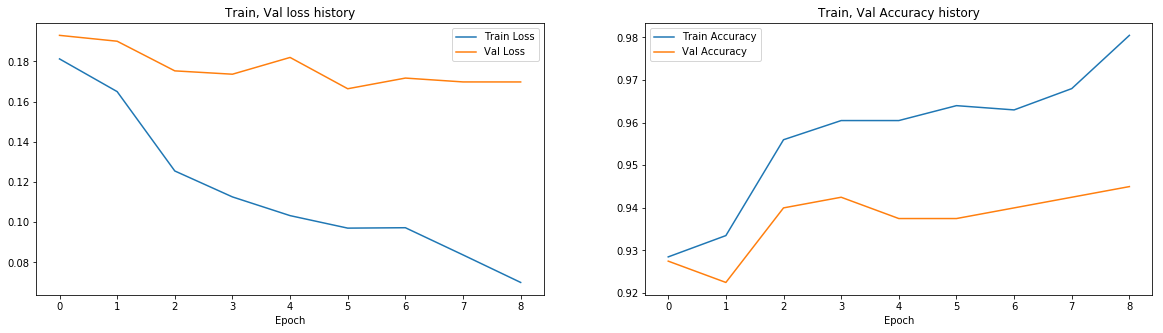

In [12]:
# Plot train and validation history
fig, axs = plt.subplots(1,2, figsize= (20,5))
axs[0].plot(train_history.history['loss'])
axs[0].plot(train_history.history['val_loss'])
axs[0].set_title("Train, Val loss history")
axs[0].set_xlabel("Epoch")
axs[0].legend(["Train Loss","Val Loss"])

axs[1].plot(train_history.history['accuracy'])
axs[1].plot(train_history.history['val_accuracy'])
axs[1].set_title("Train, Val Accuracy history")
axs[1].set_xlabel("Epoch")
axs[1].legend(["Train Accuracy","Val Accuracy"])

### Evaluate model

In [13]:
_, train_accuracy = model.evaluate(train_generator)
print("Train data accuracy:", train_accuracy)

_, test_accuracy = model.evaluate(test_generator)
print("Test data accuracy:", test_accuracy)

125/125 [==============================] - 9s 75ms/step - loss: 0.0782 - accuracy: 0.9775
Train data accuracy: 0.9775000214576721
25/25 [==============================] - 1s 25ms/step - loss: 0.1964 - accuracy: 0.9250
Test data accuracy: 0.925000011920929


In [14]:
# Get predicted value and the ground truth value of test data
pred = model.predict_classes(test_generator)
true = test_generator.classes

In [15]:
# Classification report
print(classification_report(y_true= true, y_pred = pred, target_names=['cats', 'dogs']))

             precision    recall  f1-score   support

       cats       0.91      0.94      0.93       200
       dogs       0.94      0.91      0.92       200

avg / total       0.93      0.93      0.92       400



### Perform inference on test images

In [16]:
def image_loader(img_file):
    """load individual images"""
    img = load_img(img_file, target_size = (img_width, img_height))
    imgplot = plt.imshow(img)
    plt.show()
    img = img_to_array(img) / 255
    img = np.expand_dims(img, axis = 0) #model input is (1,150,150,3)
    return img

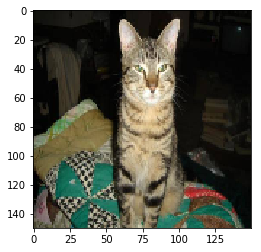

[[0.00027962]]


In [17]:
img = image_loader('../data/catsVsDogs/test/cats/cat.1070.jpg')
img_y_pred = model.predict(img) 
print(img_y_pred)

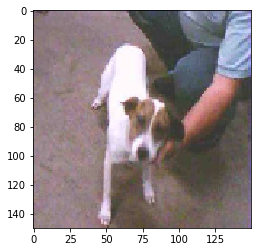

[[0.9980101]]


In [18]:
img = image_loader('../data/catsVsDogs/test/dogs/dog.1233.jpg')
img_y_pred = model.predict(img) 
print(img_y_pred)

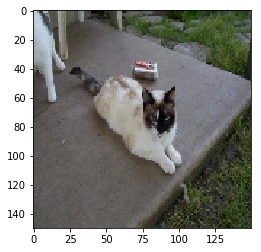

[[0.48196065]]


In [19]:
img = image_loader('../data/catsVsDogs/test/cats/cat.1195.jpg')
img_y_pred = model.predict(img) 
print(img_y_pred)

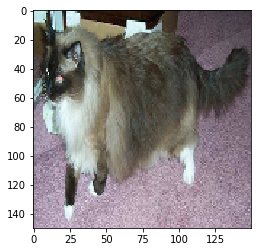

[[0.6859533]]


In [20]:
img = image_loader('../data/catsVsDogs/test/cats/cat.1011.jpg')
img_y_pred = model.predict(img) 
print(img_y_pred)

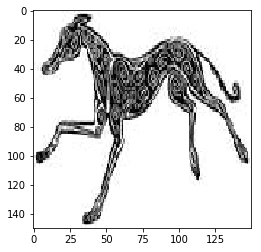

[[0.96640533]]


In [21]:
img = image_loader('../data/catsVsDogs/test/dogs/dog.1308.jpg')
img_y_pred = model.predict(img) 
print(img_y_pred)

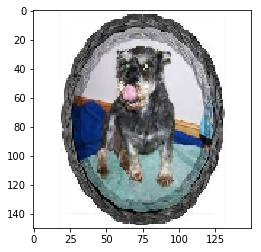

[[0.9787678]]


In [22]:
img = image_loader('../data/catsVsDogs/test/dogs/dog.1342.jpg')
img_y_pred = model.predict(img) 
print(img_y_pred)